# Pipeline for High-z Radio Galaxies 04: Radio detection classification

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

***

## Reading data

In [8]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [9]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = False

In [10]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [11]:
mqc_version = '7_4d'  # '7_2'

In [12]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [13]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [14]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [15]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [16]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [17]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 85548 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies.


---

## Possible correlations

In [18]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [19]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [20]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [21]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

## Split data: Test, Train, Validation

In [22]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2,\
     random_state=seed, stratify=full_catalog_df.loc[:, 'radio_detect'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (85548, 41)
Data for Modeling (Train and Test): (68438, 41)
Unseen Data For Validation: (17110, 41)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [27]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [23]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [24]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [25]:
rsd_vals

z_y         223.394379
i_z         212.574864
class       134.705305
r_i         113.463295
g_r          96.821881
g_i          74.614716
J_H          41.198974
H_K          32.690181
w2_w3        32.352419
band_num     21.866931
w3_w4        17.323289
gmag          7.042670
rmag          6.571578
g/J           6.330722
ymag          6.117134
imag          6.013527
zmag          5.983059
r/H           5.765099
W1mproPM      5.628783
i/K           5.588566
W1mag         5.526000
w1/w4         5.327564
W2mproPM      4.905258
w1/w3         4.780304
W2mag         4.713447
y/W2          4.617226
z/W1          4.596772
w2/w4         4.529881
r/z           3.309234
i/y           2.876422
W3mag         2.722713
NUVmag        2.070940
Hmag          2.035045
Jmag          1.960171
FUV/K         1.443960
W4mag         1.338771
Kmag          1.244955
J/K           1.021024
FUVmag        0.742347
FUV_NUV     -38.870058
w1_w2      -241.357768
dtype: float64

In [26]:
correlation = norm_train_test_df.corr()

In [27]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [28]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [29]:
target_feat = 'radio_detect'

In [30]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [31]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [32]:
list_drop_corr

['i/K',
 'w1/w4',
 'g/J',
 'Jmag',
 'w2/w4',
 'r/H',
 'FUV_NUV',
 'W3mag',
 'W2mag',
 'zmag',
 'W2mproPM',
 'Kmag',
 'imag',
 'J/K',
 'w1/w3',
 'Hmag',
 'rmag',
 'W1mag',
 'W1mproPM',
 'g_i']

In [33]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [34]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [35]:
corr_discard = norm_train_test_discard.corr()

In [36]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
class     w1_w2       0.782290
band_num  ymag        0.738434
r/z       r_i         0.689108
NUVmag    FUVmag      0.686532
band_num  gmag        0.668914
y/W2      z/W1        0.651354
gmag      ymag        0.630444
ymag      y/W2        0.602216
          w2_w3       0.578916
H_K       ymag        0.573200
i/y       z_y         0.572537
          i_z         0.564492
r/z       i_z         0.523345
NUVmag    w3_w4       0.521784
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

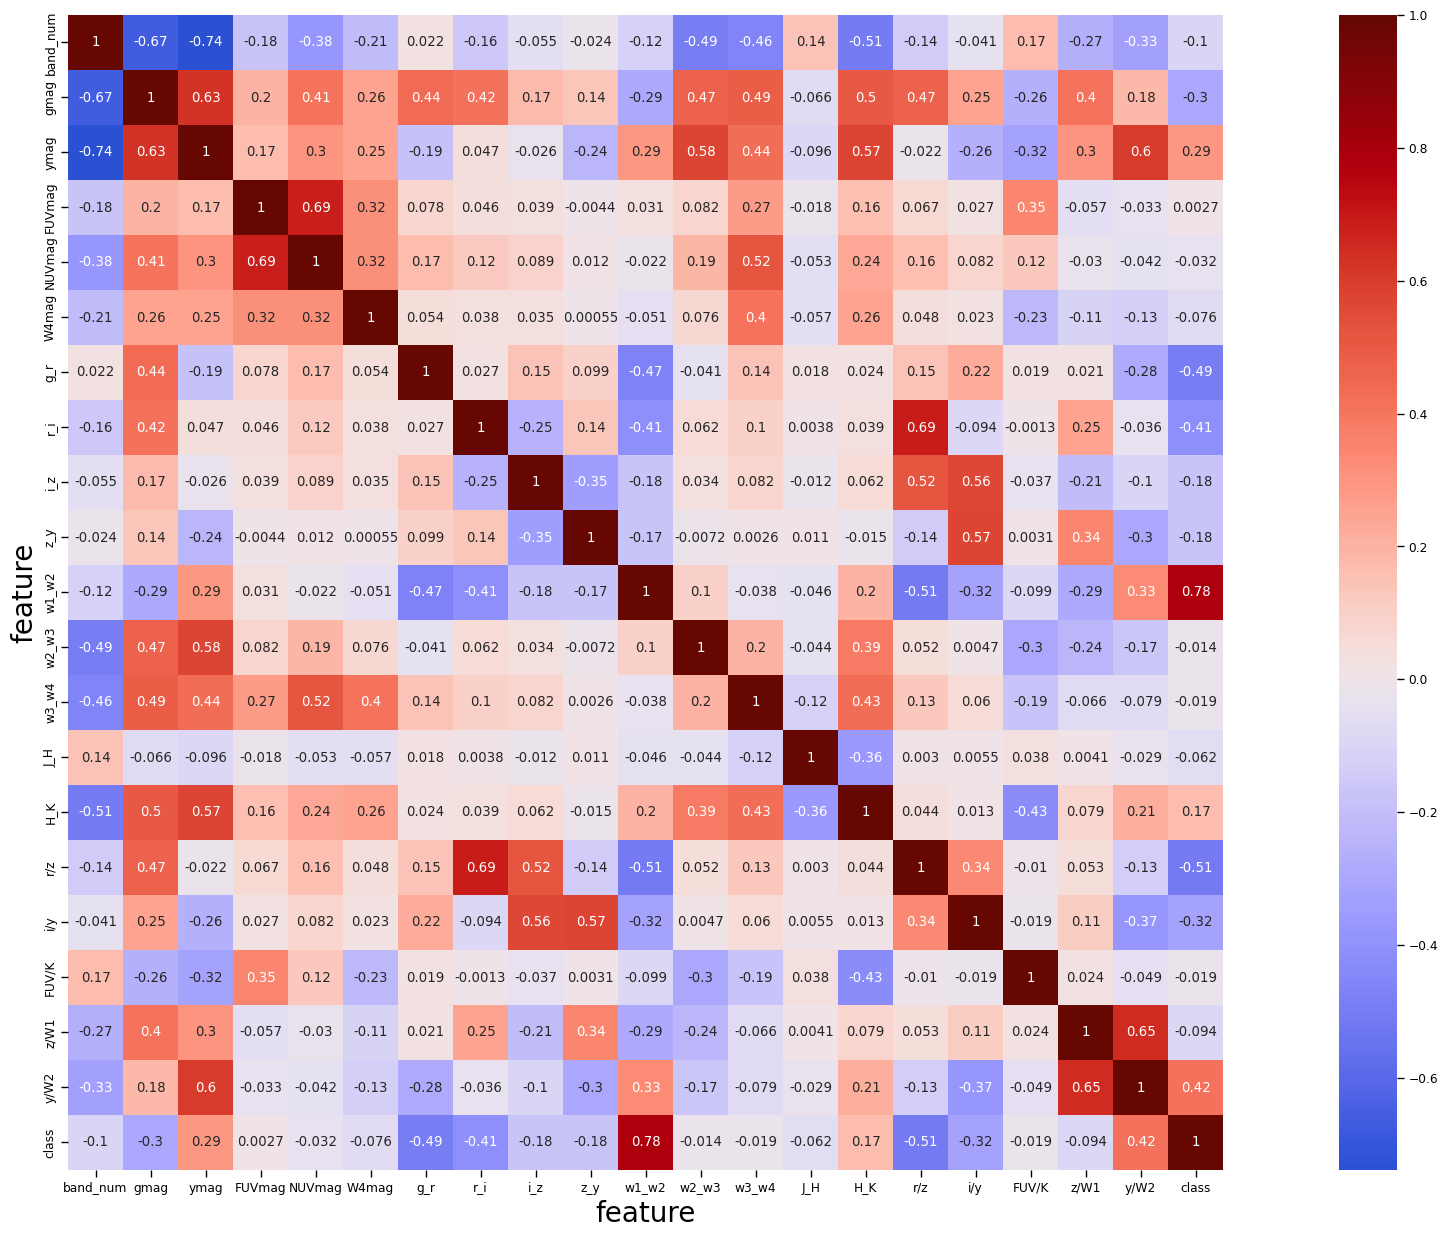

In [37]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [38]:
norm_train_test_discard.loc[:, 'radio_detect'] = norm_train_test_discard.loc[:, 'radio_detect'].astype(bool)

In [39]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [40]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y     
FUV/K     FUV/K     1.000000
w1_w2     class     0.714168
FUV/K     FUVmag    0.604958
g_r       class     0.552102
NUVmag    FUVmag    0.536125
r/z       class     0.516570
class     w1_w2     0.492046
r_i       class     0.453023
band_num  gmag      0.410168
          ymag      0.375535
J_H       H_K       0.360670
r_i       r/z       0.343060
r/z       r_i       0.307023
band_num  class     0.282483
y/W2      class     0.270876
ymag      H_K       0.253039
class     r/z       0.252503
          g_r       0.248385
i/y       class     0.247245
gmag      class     0.217317
dtype: float64

In [41]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [42]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [43]:
target_feat = 'radio_detect'

In [44]:
list_drop_pps = []

In [45]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [46]:
list_drop_pps

[]

In [47]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [48]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'radio_detect', random_seed=seed)

In [49]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.714168,classification,True,weighted F1,0.5544,0.872633,DecisionTreeClassifier()
1,g_r,class,0.552102,classification,True,weighted F1,0.5544,0.800417,DecisionTreeClassifier()
2,r/z,class,0.516570,classification,True,weighted F1,0.5544,0.784584,DecisionTreeClassifier()
3,r_i,class,0.453023,classification,True,weighted F1,0.5544,0.756267,DecisionTreeClassifier()
4,band_num,class,0.282483,classification,True,weighted F1,0.5544,0.680275,DecisionTreeClassifier()
5,y/W2,class,0.270876,classification,True,weighted F1,0.5544,0.675102,DecisionTreeClassifier()
6,i/y,class,0.247245,classification,True,weighted F1,0.5544,0.664572,DecisionTreeClassifier()
7,gmag,class,0.217317,classification,True,weighted F1,0.5544,0.651236,DecisionTreeClassifier()
8,i_z,class,0.176033,classification,True,weighted F1,0.5544,0.632840,DecisionTreeClassifier()
9,ymag,class,0.131645,classification,True,weighted F1,0.5544,0.613061,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [50]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
# final_feats = pps_pred_target.x.to_list()  # After Boruta

In [51]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [52]:
exp_radio = pyc.setup(data=train_test_df, target='radio_detect', session_id=seed, silent=True,\
                    feature_selection=True, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(68438, 41)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [53]:
pyc.get_config('X').columns

Index(['band_num', 'gmag', 'ymag', 'FUVmag', 'NUVmag', 'W4mag', 'g_r', 'r_i',
       'i_z', 'z_y', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'r/z', 'i/y',
       'FUV/K', 'z/W1', 'y/W2'],
      dtype='object')

In [54]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [55]:
# used_models_clf      = ['catboost','xgboost', 'lightgbm', 'rf', 'et', 'lr', 'dt', 'svm', 'lda']  # knn too slow, ridge does not work
final_selection_clf  = ['catboost', 'rf', 'lightgbm', 'et', 'xgboost', 'dummy']
n_models             = 5
top_model_radio = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, sort='MCC')  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9496,0.9837,0.9147,0.9417,0.9280,0.8892,0.8894,2.0690
rf,Random Forest Classifier,0.9490,0.9813,0.9106,0.9440,0.9270,0.8879,0.8882,0.8100
lightgbm,Light Gradient Boosting Machine,0.9490,0.9836,0.9142,0.9405,0.9272,0.8879,0.8882,28.0760
et,Extra Trees Classifier,0.9482,0.9807,0.9097,0.9425,0.9258,0.8860,0.8864,0.2600
xgboost,Extreme Gradient Boosting,0.9480,0.9825,0.9130,0.9390,0.9258,0.8858,0.8861,9.2760
dummy,Dummy Classifier,0.6447,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [56]:
stacked_model_radio = pyc.stack_models(estimator_list=top_model_radio[1:], meta_model=top_model_radio[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9505,0.9838,0.9207,0.9389,0.9297,0.8916,0.8917
1,0.9543,0.9846,0.9195,0.9502,0.9346,0.8995,0.8998
2,0.9495,0.9842,0.9177,0.9387,0.9281,0.8892,0.8893
3,0.9441,0.9806,0.9048,0.9356,0.9200,0.8770,0.8773
4,0.9451,0.9812,0.9054,0.9379,0.9214,0.8792,0.8796
5,0.9482,0.9818,0.9166,0.9364,0.9264,0.8865,0.8866
6,0.9526,0.9856,0.9266,0.9392,0.9329,0.8962,0.8963
7,0.9474,0.9842,0.9266,0.9255,0.9260,0.8852,0.8852
8,0.9572,0.9882,0.9313,0.9474,0.9393,0.9062,0.9063


In [57]:
tuned_radio_clf = pyc.tune_model(stacked_model_radio, early_stopping='asha', optimize='MCC',\
                               search_library='tune-sklearn', search_algorithm='random')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9503,0.9838,0.9225,0.9368,0.9296,0.8912,0.8913
1,0.9539,0.9849,0.9183,0.9502,0.9340,0.8985,0.8988
2,0.9520,0.9849,0.9183,0.9450,0.9315,0.8945,0.8948
3,0.9436,0.9808,0.9036,0.9355,0.9193,0.8760,0.8763
4,0.9441,0.9820,0.9083,0.9324,0.9202,0.8772,0.8774
5,0.9491,0.9823,0.9166,0.9386,0.9275,0.8882,0.8884
6,0.9530,0.9862,0.9248,0.9420,0.9333,0.8970,0.8971
7,0.9489,0.9841,0.9224,0.9329,0.9276,0.8881,0.8881
8,0.9549,0.9887,0.9242,0.9476,0.9358,0.9010,0.9012


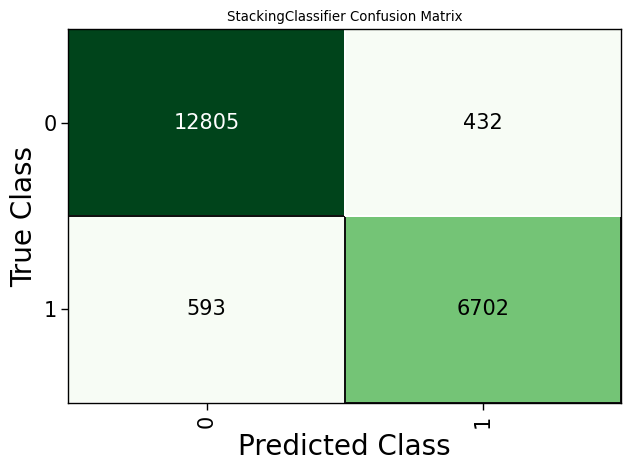

In [58]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

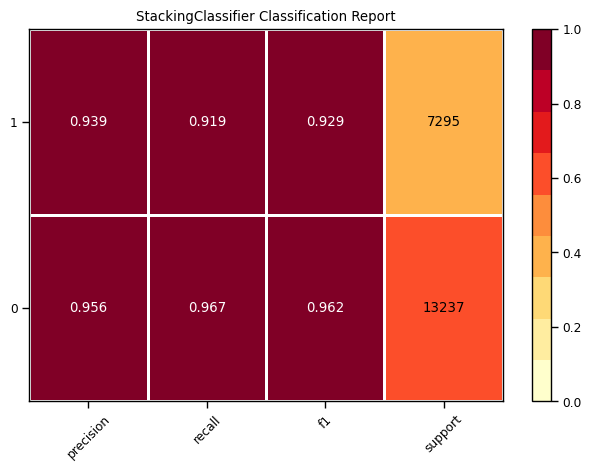

In [59]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

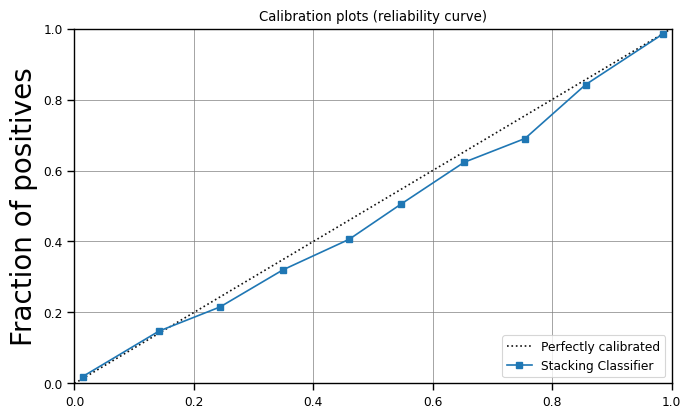

In [60]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

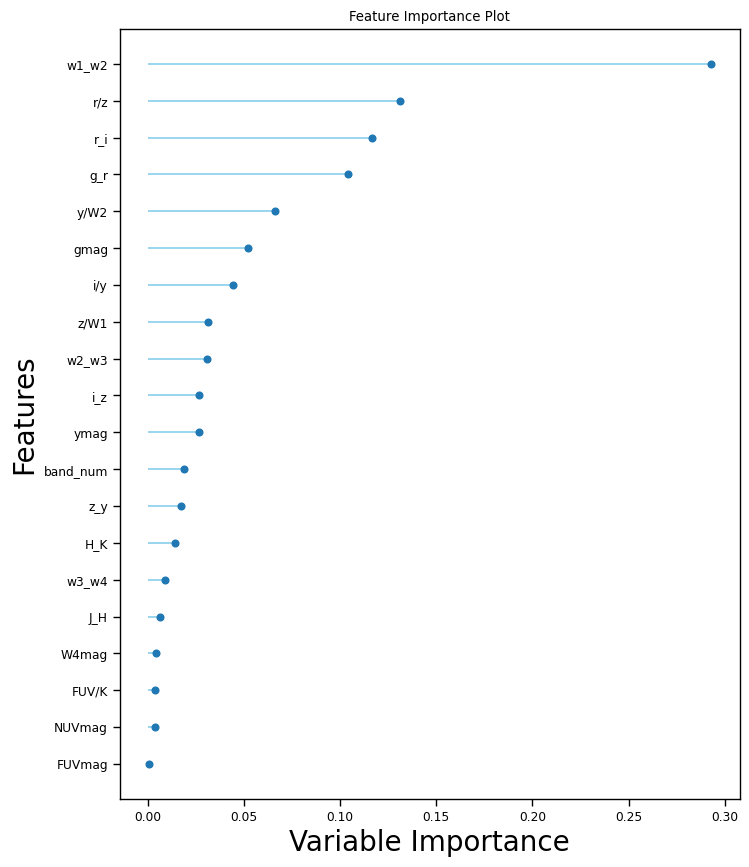

In [61]:
pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [62]:
pyc.plot_model(tuned_radio_clf, plot='parameter')

,Parameters
cv,5
estimators,"[('rf', RandomForestClassifier(bootstrap=True,..."
final_estimator,<catboost.core.CatBoostClassifier object at 0x...
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [63]:
plt.rcParams.update(plt.rcParamsDefault)

In [64]:
pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9501,0.9850,0.9187,0.9394,0.9290,0.8905,0.8906


,band_num,gmag,ymag,FUVmag,NUVmag,W4mag,g_r,r_i,i_z,z_y,...,H_K,r/z,i/y,FUV/K,z/W1,y/W2,class,Label,Score_0,Score_1
0,0.330891,-0.113242,0.589152,0.157379,0.355869,0.202725,-0.864058,0.035725,-0.342749,0.164152,...,0.340844,-0.266919,-0.180432,-0.066972,0.234518,0.356623,1,1,0.0201,0.9799
1,0.757557,-1.677293,-0.898863,0.157379,-2.884640,-4.874414,-0.711718,-1.016473,-0.439741,-0.634078,...,0.340844,-1.248306,-0.976622,-0.066972,-0.522038,0.991584,1,1,0.0050,0.9950
2,-1.272924,1.382771,-0.641896,0.157379,0.355869,0.202725,2.797009,-6.370238,1.094413,5.737082,...,0.340844,-3.961715,6.134332,-0.066972,2.532855,-1.339728,0,0,0.9888,0.0112
3,-0.489590,0.217749,1.588654,0.157379,0.355869,0.202725,-0.584452,-0.504485,-0.106048,-1.099199,...,0.340844,-0.562810,-1.039337,-0.066972,0.140404,1.612456,1,1,0.0111,0.9889
4,-0.085322,0.320472,-0.555814,0.157379,0.355869,0.202725,0.921009,0.442293,0.570698,-0.019047,...,0.340844,0.869423,0.527794,-0.066972,0.525618,-0.016272,0,0,0.9908,0.0092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.085322,-1.553072,-0.851244,0.157379,0.355869,0.202725,-0.909395,-1.305663,0.106532,-0.230889,...,0.340844,-1.033976,-0.057948,-0.066972,-1.608916,-0.761561,1,1,0.0050,0.9950
20528,1.192371,0.123455,-0.414501,0.157379,0.355869,0.202725,0.499505,0.298975,0.450346,0.031652,...,0.340844,0.633880,0.457203,-0.066972,0.337436,-0.065260,0,0,0.9840,0.0160
20529,0.330891,-0.638831,0.085842,0.157379,0.355869,0.202725,-0.579986,-0.389697,-0.398067,-0.198364,...,0.340844,-0.659760,-0.538709,-0.066972,-1.517640,-0.985219,0,1,0.4689,0.5311
20530,-0.085322,0.197329,-0.227169,0.157379,0.355869,0.202725,0.372862,0.075488,0.448544,0.244724,...,0.340844,0.405300,0.626414,-0.066972,-0.843572,-0.951424,0,0,0.9404,0.0596


In [65]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9501,0.9850,0.9187,0.9394,0.9290,0.8905,0.8906


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [66]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

In [67]:
if save_model_flag:
    if use_5sigma:
        pyc.save_model(final_radio_clf, 'models/classification_radio_detect_apr_27_2022')  # Model (it will be saved with .pkl extension)
        # pyc.save_config('../../models/config_classification_radio_detect_apr_27_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [68]:
if load_model_flag:
    final_radio_clf = pyc.load_model('models/classification_radio_detect_apr_27_2022')

### Prediction process

#### Feature importances

In [69]:
extended_data_radio = validation_df.loc[:, get_final_column_names(final_radio_clf, validation_df)].copy()
extended_idx_radio  = extended_data_radio.index
initial_cols_radio  = extended_data_radio.columns
extended_cols_radio = extended_data_radio.columns.insert(0, 'rf')
extended_cols_radio = extended_cols_radio.insert(0, 'lightgbm')
extended_cols_radio = extended_cols_radio.insert(0, 'et')
extended_cols_radio = extended_cols_radio.insert(0, 'xgboost')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [70]:
print('Running data pre-processing:\n')
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_radio_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_radio = method.transform(extended_data_radio)
extended_data_radio_df = pd.DataFrame(extended_data_radio, columns=extended_cols_radio, index=extended_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [71]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    importances_coef = final_radio_clf.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_radio_clf.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_radio, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [72]:
if isinstance(final_radio_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_radio_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_radio_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_radio_clf.estimators
    estimators_list_ = final_radio_clf.estimators_

In [73]:
base_models_names = [model[0] for model in estimators_list]

In [74]:
coef_sorted_base_df = {}

In [75]:
for model, model_fit in zip(base_models_names, estimators_list_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_radio.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_radio.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [77]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [78]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for rf...
Calculating for lightgbm...
Calculating for et...
Calculating for xgboost...


rf             lightgbm                   et              xgboost  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  28.783206     w1_w2  10.800000     w1_w2  33.494765     w1_w2   
1        r/z  13.748579     w2_w3  10.266667      gmag  10.407363       r/z   
2        r_i  11.148273       g_r   9.300000       g_r   7.486392      y/W2   
3        g_r  10.613189       r/z   8.166667      ymag   7.184761     w2_w3   
4       y/W2   6.622074      gmag   6.866667       r/z   6.642163     w3_w4   
5       gmag   5.085958      ymag   6.433333      y/W2   5.605816       g_r   
6        i/y   4.476994      z/W1   6.433333       r_i   4.950921      ymag   
7       ymag   3.210881       r_i   6.300000  band_num   4.176399      gmag   
8       z/W1   2.998381      y/W2   6.233333      z/W1   3.768177     W4mag   
9      w2_w3   2.904613       i/y   5.566667       i/y   3.499426  band_num   
10       i_z   2.713932       i_z   5.300000     w2_w3   3.303939      z/W1   
11  band_num   2.049536     w3_w4   4.533333       i_z   2.318488       r_i   
12       z_y   1.723387  band_num   3.633333       z_y   1.966051    NUVmag   
13       H_K   1.158558       z_y   3.433333     w3_w4   1.279290       i/y   
14     w3_w4   0.894215    NUVmag   1.733333       H_K   0.913196       i_z   
15       J_H   0.650241       H_K   1.566667     W4mag   0.909582       H_K   
16    NUVmag   0.378724     W4mag   1.333333    NUVmag   0.847589     FUV/K   
17     FUV/K   0.377080     FUV/K   1.066667       J_H   0.554468       z_y   
18     W4mag   0.358987       J_H   1.000000     FUV/K   0.374660       J_H   
19    FUVmag   0.103193    FUVmag   0.033333    FUVmag   0.316553    FUVmag   

               
   Importance  
0   55.967968  
1   10.332925  
2    5.842956  
3    4.290623  
4    2.953234  
5    2.546161  
6    2.457378  
7    2.410675  
8    1.576698  
9    1.543132  
10   1.508464  
11   1.475048  
12   1.364476  
13   1.089148  
14   1.042412  
15   0.831650  
16   0.777145  
17   0.773110  
18   0.630705  
19   0.586099

In [79]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,31.810909
1,rf,27.565594
2,xgboost,12.483650
3,lightgbm,10.144322
4,w2_w3,2.938423
5,w1_w2,2.107527
6,ymag,1.927292
7,gmag,1.837488
8,r_i,1.595995
9,r/z,1.156308


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	10.829
w2_w3	10.260
g_r	9.298
r/z	8.169
gmag	6.866
ymag	6.431
z/W1	6.430
r_i	6.300
y/W2	6.233
i/y	5.564
i_z	5.297
w3_w4	4.531
band_num	3.632
z_y	3.431
NUVmag	1.732
H_K	1.566
W4mag	1.333
FUV/K	1.066
J_H	1.000
FUVmag	0.034


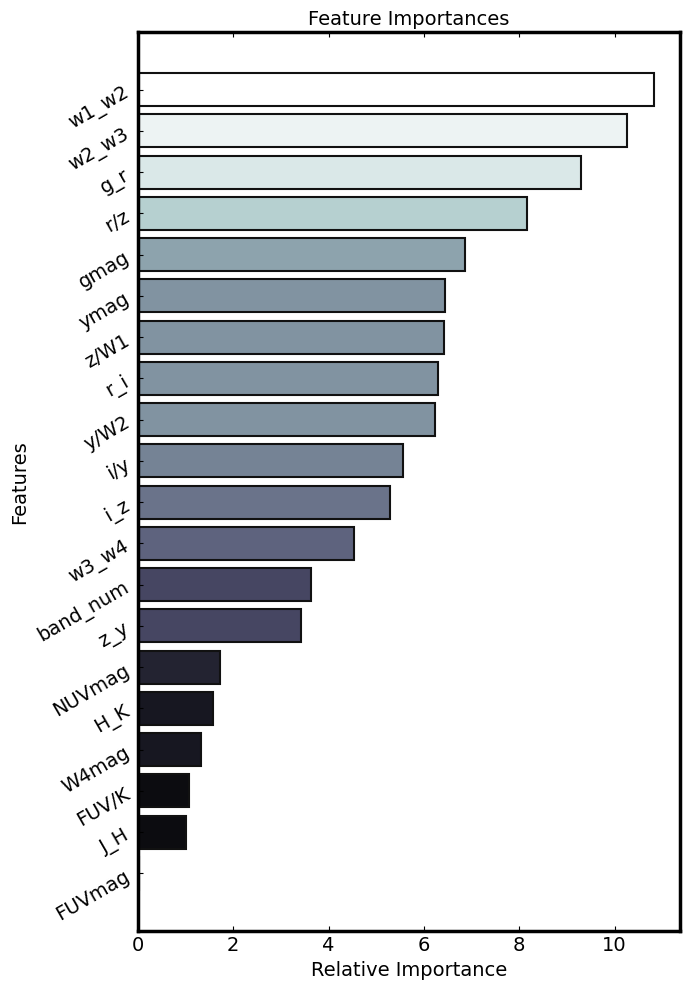

In [80]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_radio_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_radio_detect_01.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [81]:
radio_pred_threshold = 0.5
# radio_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [82]:
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9490,0.9847,0.9118,0.9428,0.9271,0.8879,0.8882


Create confusion matrix with validation data.

In [83]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['radio_detect'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

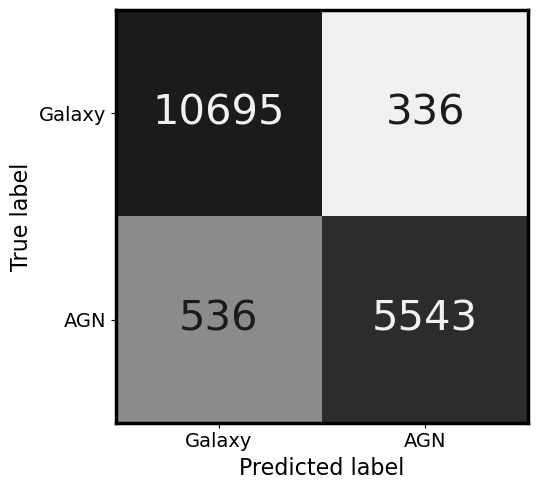

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['No\nRadio', 'Radio'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_radio_detect_01.pdf', bbox_inches='tight')
plt.show()

In [85]:
TN_radio, FP_radio, FN_radio, TP_radio = cm_mat_val.flatten().astype('float32')

In [86]:
MCC_radio_val = ((TP_radio * TN_radio) - (FP_radio * FN_radio)) /\
            np.sqrt((TP_radio + FP_radio) * (TP_radio + FN_radio) * (TN_radio + FP_radio) * (TN_radio + FN_radio))

ACC_radio_val = (TP_radio + TN_radio) / (TP_radio + TN_radio + FP_radio + FN_radio)

F1_radio_val  = 2 * TP_radio / (2 * TP_radio + FP_radio + FN_radio)

Recall_radio_val = TP_radio / (TP_radio + FN_radio)

In [87]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_val:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_val:.4f}')
print(f'F1-score is                          F1 = {F1_radio_val:.4f}')
print(f'Recall is                           TPR = {Recall_radio_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8882
Accuracy is ACC = 0.9490
F1-score is F1 = 0.9271
Recall is TPR = 0.9118


In [88]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['radio_detect']), train_test_df.loc[:, 'radio_detect'], False, 'radio_detect'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['radio_detect']),
                train_test_df.loc[:, 'radio_detect'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [89]:
train_prediction_clf = pyc.predict_model(final_radio_clf, data=train_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9815,0.9993,0.9590,0.9889,0.9737,0.9595,0.9598


In [90]:
test_prediction_clf = pyc.predict_model(final_radio_clf, data=test_data_df, probability_threshold=radio_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9833,0.9993,0.9618,0.9906,0.9760,0.9632,0.9635


In [91]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['radio_detect'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [92]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
        [np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['radio_detect'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

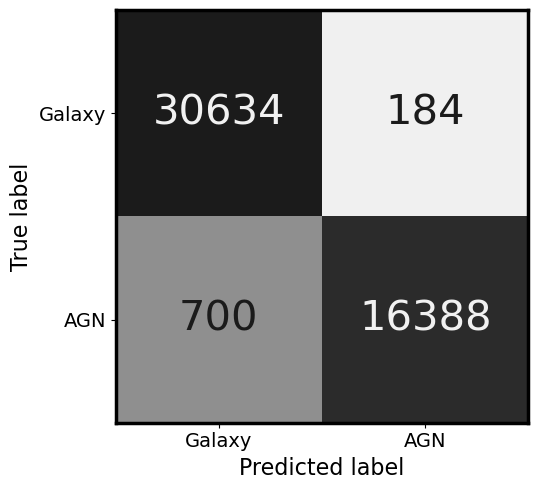

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['No\nRadio', 'Radio'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_radio_detect_01.pdf', bbox_inches='tight')
plt.show()

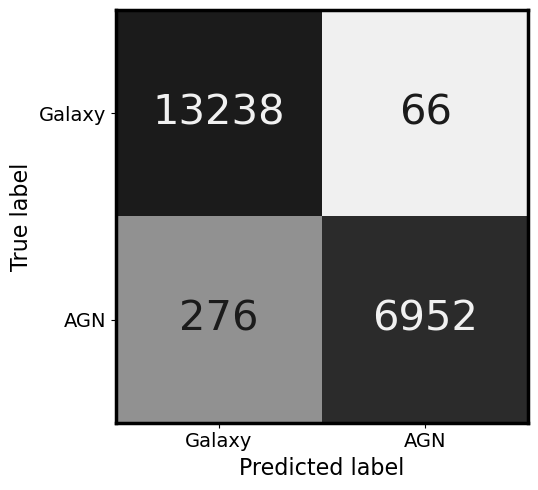

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['No\nRadio', 'Radio'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_radio_detect_01.pdf', bbox_inches='tight')
plt.show()

In [95]:
TN_radio_train, FP_radio_train, FN_radio_train, TP_radio_train = cm_mat_train.flatten().astype('float32')

In [96]:
MCC_radio_train = ((TP_radio_train * TN_radio_train) - (FP_radio_train * FN_radio_train)) /\
            np.sqrt((TP_radio_train + FP_radio_train) * (TP_radio_train + FN_radio_train) * 
                    (TN_radio_train + FP_radio_train) * (TN_radio_train + FN_radio_train))

ACC_radio_train = (TP_radio_train + TN_radio_train) / (TP_radio_train + TN_radio_train + FP_radio_train + FN_radio_train)

F1_radio_train  = 2 * TP_radio_train / (2 * TP_radio_train + FP_radio_train + FN_radio_train)

Recall_radio_train = TP_radio_train / (TP_radio_train + FN_radio_train)

In [97]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_train:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_train:.4f}')
print(f'F1-score is                          F1 = {F1_radio_train:.4f}')
print(f'Recall is                           TPR = {Recall_radio_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.9598
Accuracy is ACC = 0.9815
F1-score is F1 = 0.9737
Recall is TPR = 0.9590


In [98]:
TN_radio_test, FP_radio_test, FN_radio_test, TP_radio_test = cm_mat_test.flatten().astype('float32')

In [99]:
MCC_radio_test = ((TP_radio_test * TN_radio_test) - (FP_radio_test * FN_radio_test)) /\
            np.sqrt((TP_radio_test + FP_radio_test) * (TP_radio_test + FN_radio_test) * 
                    (TN_radio_test + FP_radio_test) * (TN_radio_test + FN_radio_test))

ACC_radio_test = (TP_radio_test + TN_radio_test) / (TP_radio_test + TN_radio_test + FP_radio_test + FN_radio_test)

F1_radio_test  = 2 * TP_radio_test / (2 * TP_radio_test + FP_radio_test + FN_radio_test)

Recall_radio_test = TP_radio_test / (TP_radio_test + FN_radio_test)

In [100]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_radio_test:.4f}')
print(f'Accuracy is                         ACC = {ACC_radio_test:.4f}')
print(f'F1-score is                          F1 = {F1_radio_test:.4f}')
print(f'Recall is                           TPR = {Recall_radio_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.9635
Accuracy is ACC = 0.9833
F1-score is F1 = 0.9760
Recall is TPR = 0.9618


Calculate ROC AUC values and plots.

In [101]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

In [102]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99925
Area under the curve (ROC) for test       = 0.99929
Area under the curve (ROC) for validation = 0.98474


In [103]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_clf.loc[:, 'radio_detect'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_clf.loc[:, 'radio_detect'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_clf.loc[:, 'radio_detect'], validation_prediction_clf.loc[:, 'Score_1'])

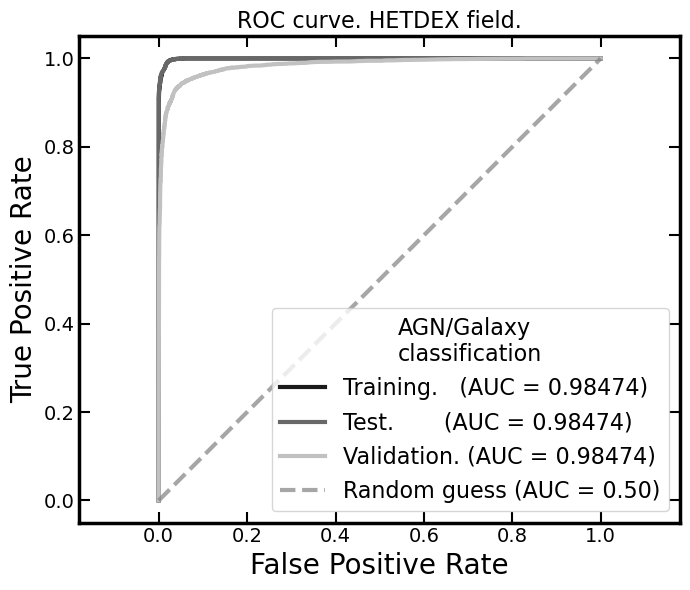

/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.anaconda3/envs/pycaret2_3_10/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future re

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='Radio detection\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_radio_detect_01.pdf', bbox_inches='tight')
plt.show()